In [3]:
import torch
from collections import OrderedDict
from torch.optim import Adam
from torch import nn

from backbone import resnet18
from neck import FPN
from head import DBHead
from loss import DBLoss
from WarmupPolyLR import WarmupPolyLR

model = nn.Sequential(OrderedDict([
                                   ('backbone', resnet18(pretrained=True)),
                                   ('neck', FPN([64,128,256,512])),
                                   ('head', DBHead(256))
]))

In [4]:
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
from datasets.ICDAR2015Dataset import ICDAR2015Dataset, ICDARCollectFN
from torchvision import transforms

def get_transforms(transforms_config):
    tr_list = []
    for item in transforms_config:
        if 'args' not in item:
            args = {}
        else:
            args = item['args']
        cls = getattr(transforms, item['type'])(**args)
        tr_list.append(cls)
    tr_list = transforms.Compose(tr_list)
    return tr_list
    
img_transfroms = get_transforms([{'args': {}, 'type': 'ToTensor'},
 {'args': {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]},
  'type': 'Normalize'}])


data_validation = ICDAR2015Dataset(['data/streets/test.txt'],img_mode= 'RGB',filter_keys=[],
                                   ignore_tags= ['*', '###'], 
                                   transform=img_transfroms,
                                   pre_processes=[
                                       {'args': {'shrink_ratio': 0.4, 'thresh_max': 0.7, 'thresh_min': 0.3},
                                        'type': 'MakeBorderMap'},
                                       {'args': {'min_text_size': 8, 'shrink_ratio': 0.4}, 'type': 'MakeShrinkMap'}],)

<IPython.core.display.Javascript object>


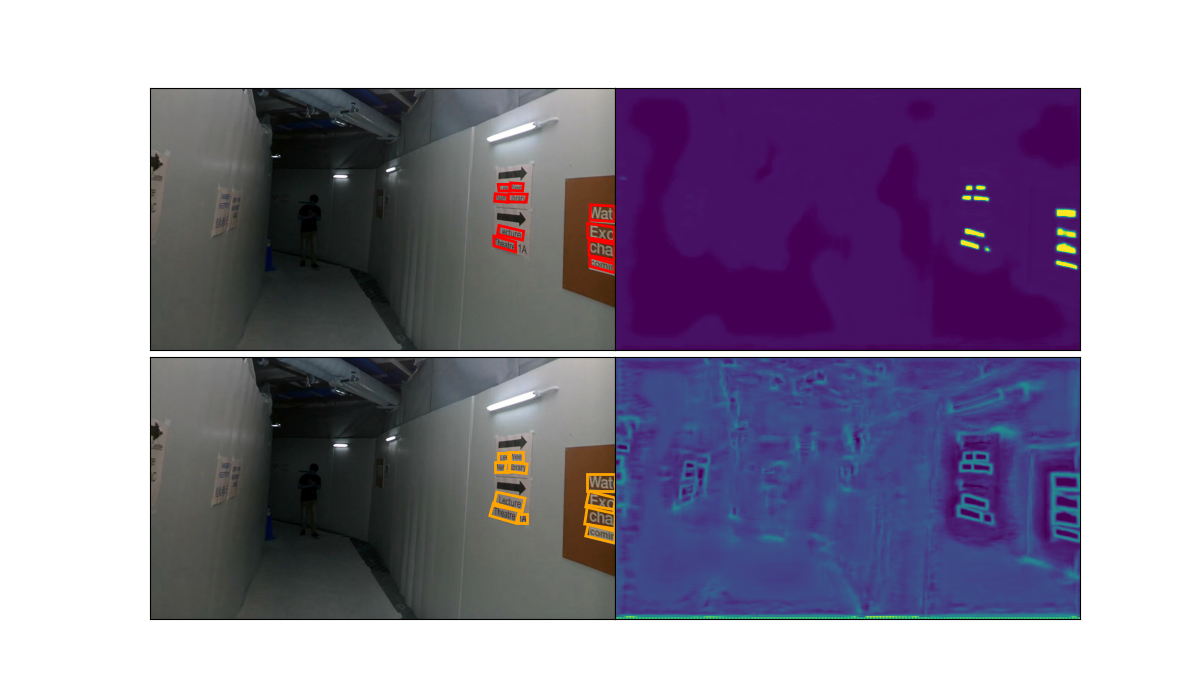

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import collections  as mc
import matplotlib.image as mpimg
import torch
import cv2
import numpy as np
%matplotlib notebook

from representer import SegDetectorRepresenter
representer = SegDetectorRepresenter(box_thresh = .2)



imgdata = data_validation[200]
img = cv2.imread(imgdata['img_path'], 1)

with torch.no_grad():
    output = model(imgdata['img'][None])
    output = output[0]





fig, ax = plt.subplots(2,2, figsize = (12, 7))


#res = cv2.resize(img, dsize=(output[2].shape[1],output[2].shape[0]), interpolation=cv2.INTER_CUBIC)

#img = 1 - img
ax[0,0].imshow(img)
ax[1,0].imshow(img)

ax[0,1].imshow(output[0])
ax[1,1].imshow(output[1])

imgdatabatch = {k:[v] for k,v in imgdata.items()}
imgdatabatch['shape'] = [imgdata['threshold_map'].shape]

boxes = representer(imgdatabatch, pred = output[None])[0][0]

for i, box in enumerate(imgdata['text_polys']):
    if not imgdata['ignore_tags'][i]:
        ax[0,0].add_patch(matplotlib.patches.Polygon(box, fill=False, edgecolor='red', lw = 2))
    
for box in boxes:
    ax[1,0].add_patch(matplotlib.patches.Polygon(box, fill=False, edgecolor='orange', lw = 2))

    
plt.subplots_adjust(wspace=0, hspace=0)
for ax1 in ax:
    for ax2 in ax1:
        ax2.set_xticks([])
        ax2.set_yticks([])
#plt.subplot_tool() 
#plt.show()